In [79]:
# from google.colab import drive
# drive.mount('/content/drive')

# 0. Preamble

In [80]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
import os

In [81]:
# notebook_path = '/content/drive/MyDrive/Colab_Notebooks/ISER/code/'
# os.chdir(notebook_path)

In this section, I import the dataset located in the raw data folder asa dataframe and clean the column names.

In [82]:
data = pd.read_csv("../raw_data/global_crisis_data_country.csv", encoding='unicode_escape')

In [83]:
print(data.shape)
data.head()

(15191, 27)


,Case,CC3,Country,Year,Banking Crisis,Banking_Crisis_Notes,Systemic Crisis,Gold Standard,exch_usd,exch_usd_alt1,...,Domestic_Debt_ Notes/Sources,"SOVEREIGN EXTERNAL DEBT 1: DEFAULT and RESTRUCTURINGS, 1800-2012--Does not include defaults on WWI debt to United States and United Kingdom and post-1975 defaults on Official External Creditors","SOVEREIGN EXTERNAL DEBT 2: DEFAULT and RESTRUCTURINGS, 1800-2012--Does not include defaults on WWI debt to United States and United Kingdom but includes post-1975 defaults on Official External Creditors",Defaults_External_Notes,GDP_Weighted_default,<,"Inflation, Annual percentages of average consumer prices",Independence,Currency Crises,Inflation Crises
0,NaN,NaN,NaN,NaN,x,NaN,x,x,NaN,NaN,...,NaN,x,NaN,NaN,x,x,NaN,x,x,x
1,1.0,DZA,Algeria,1800.0,0,NaN,0,0,NaN,NaN,...,NaN,0,0.0,NaN,0,NaN,NaN,0,0,0
2,1.0,DZA,Algeria,1801.0,0,NaN,0,0,NaN,NaN,...,NaN,0,0.0,NaN,0,NaN,NaN,0,0,0
3,1.0,DZA,Algeria,1802.0,0,NaN,0,0,NaN,NaN,...,NaN,0,0.0,NaN,0,NaN,NaN,0,0,0
4,1.0,DZA,Algeria,1803.0,0,NaN,0,0,NaN,NaN,...,NaN,0,0.0,NaN,0,NaN,NaN,0,0,0


In [84]:
data.columns

Index(['Case', 'CC3', 'Country', 'Year', 'Banking Crisis ',
       'Banking_Crisis_Notes', 'Systemic Crisis', 'Gold Standard', 'exch_usd',
       'exch_usd_alt1', 'exch_usd_alt2', 'exch_usd_alt3', 'conversion_notes',
       'national currency', 'exch_primary source code', 'exch_sources',
       'Domestic_Debt_In_Default', 'Domestic_Debt_ Notes/Sources',
       'SOVEREIGN EXTERNAL DEBT 1: DEFAULT and RESTRUCTURINGS, 1800-2012--Does not include defaults on WWI debt to United States and United Kingdom and post-1975 defaults on Official External Creditors',
       'SOVEREIGN EXTERNAL DEBT 2: DEFAULT and RESTRUCTURINGS, 1800-2012--Does not include defaults on WWI debt to United States and United Kingdom but includes post-1975 defaults on Official External Creditors',
       'Defaults_External_Notes', 'GDP_Weighted_default', '<',
       'Inflation, Annual percentages of average consumer prices',
       'Independence', 'Currency Crises', 'Inflation Crises'],
      dtype='object')

In [85]:
data.drop(0, inplace = True)
data.shape

(15190, 27)

In [86]:
data.rename(columns={'Banking Crisis ':'banking_crisis',
                    'Systemic Crisis':'systemic_crisis',
                    'Banking_Crisis_Notes':'notes',
                    'Gold Standard':'gold_standard',
                    'SOVEREIGN EXTERNAL DEBT 1: DEFAULT and RESTRUCTURINGS, 1800-2012--Does not include defaults on WWI debt to United States and United Kingdom and post-1975 defaults on Official External Creditors': 'sovereign_external_debt_1',
                    'SOVEREIGN EXTERNAL DEBT 2: DEFAULT and RESTRUCTURINGS, 1800-2012--Does not include defaults on WWI debt to United States and United Kingdom but includes post-1975 defaults on Official External Creditors': 'sovereign_external_debt_2',
                    'Inflation, Annual percentages of average consumer prices':'annual_inflation'},
            inplace = True)
data['Year'] = data['Year'].astype(int)

In [87]:
data['banking_crisis'] = pd.to_numeric(data['banking_crisis'], errors='coerce')
data['systemic_crisis'] = pd.to_numeric(data['systemic_crisis'], errors='coerce')
data['annual_inflation'] = pd.to_numeric(data['annual_inflation'], errors='coerce')

In [88]:
data.dtypes

Case                            float64
CC3                              object
Country                          object
Year                              int64
banking_crisis                  float64
notes                            object
systemic_crisis                 float64
gold_standard                    object
exch_usd                         object
exch_usd_alt1                   float64
exch_usd_alt2                    object
exch_usd_alt3                    object
conversion_notes                 object
national currency                object
exch_primary source code         object
exch_sources                     object
Domestic_Debt_In_Default         object
Domestic_Debt_ Notes/Sources     object
sovereign_external_debt_1        object
sovereign_external_debt_2       float64
Defaults_External_Notes          object
GDP_Weighted_default             object
<                                object
annual_inflation                float64
Independence                     object


# 1. Description of the "Global Crises Data by Country" dataset

## 1.1 Get the number of crisis per country

In [89]:
nb_countries = data["Country"].nunique()
min_year = data["Year"].min()
max_year = data["Year"].max()
nb_observations = max_year - min_year +1
print(f"There are data of {nb_countries} countries in the dataset from {min_year} to {max_year}.")

There are data of 70 countries in the dataset from 1800 to 2016.


We are interested in the number of shocks each country encountered during the period. <br>
Let's try to count the number of banking crisis and systemic crisis for each country.

In [90]:
banking_crisis_per_country = data.groupby('Country')['banking_crisis'].sum().astype(int)
systemic_crisis_per_country = data.groupby('Country')['systemic_crisis'].sum().astype(int)

Note: In the data, a banking crisis and a systemic crisis can be recorded the same year.

In [91]:
results = pd.DataFrame({
                     'banking_crisis_number': banking_crisis_per_country,
                     'systemic_crisis_number': systemic_crisis_per_country
                     })
results.sort_values(by='banking_crisis_number', ascending=False, inplace = True)
results

,banking_crisis_number,systemic_crisis_number
Country,,
United States,33,20
United Kingdom,33,20
Spain,30,13
France,26,15
Italy,26,7
...,...,...
Panama,2,2
Singapore,1,0
Mauritius,1,0


In [92]:
results.describe().round(1)

,banking_crisis_number,systemic_crisis_number
count,70.0,70.0
mean,11.5,8.1
std,7.6,5.7
min,0.0,0.0
25%,6.2,4.0
50%,11.0,7.0
75%,15.0,11.8
max,33.0,23.0


## 1.2 Get the number of negative demand shock and the frequency of crisis for each country

An first approach can be to describe a negative demand shock by a year when either a banking crisis or a systemic crisis occured, and the annual inflation was recorded as negative. This section is getting the number of episode of negative demand shock according to that definition.

In [93]:
data['neg_demand_shock'] = ((data['banking_crisis'] == 1) | (data['systemic_crisis'] == 1)) & (data['annual_inflation'] < 0)

In [94]:
crisis_df = pd.DataFrame({'nb_neg_demand_shock' : data.groupby('Country')['neg_demand_shock'].sum().astype(int)})
crisis_df['frequency'] = (crisis_df['nb_neg_demand_shock']/nb_observations).round(2)
crisis_df.sort_values(by ='nb_neg_demand_shock', ascending=False, inplace=True)

In [95]:
crisis_df

,nb_neg_demand_shock,frequency
Country,,
United States,14,0.06
United Kingdom,12,0.06
Japan,11,0.05
France,10,0.05
Sweden,10,0.05
...,...,...
Morocco,0,0.00
Myanmar,0,0.00
New Zealand,0,0.00


# 2. Estimating the inflation response to liquidity shocks - focus on the USA

## 2.1 Extract USA data

In [96]:
USA_data = data[data["CC3"]=='USA']

In [97]:
USA_data.head()

,Case,CC3,Country,Year,banking_crisis,notes,systemic_crisis,gold_standard,exch_usd,exch_usd_alt1,...,sovereign_external_debt_1,sovereign_external_debt_2,Defaults_External_Notes,GDP_Weighted_default,<,annual_inflation,Independence,Currency Crises,Inflation Crises,neg_demand_shock
14106,66.0,USA,United States,1800,0.0,NaN,0.0,0,4.462293619,NaN,...,0,0.0,NaN,0,1,2.0,1,0,0,False
14107,66.0,USA,United States,1801,0.0,NaN,0.0,0,4.363001745,NaN,...,0,0.0,NaN,0,0,1.3,1,0,0,False
14108,66.0,USA,United States,1802,0.0,NaN,0.0,0,4.474272931,NaN,...,0,0.0,NaN,0,0,-15.7,1,0,0,False
14109,66.0,USA,United States,1803,0.0,NaN,0.0,0,4.662004662,NaN,...,0,0.0,NaN,0,0,5.4,1,0,0,False
14110,66.0,USA,United States,1804,0.0,NaN,0.0,0,4.528985507,NaN,...,0,0.0,NaN,0,0,4.4,1,0,0,False


## 2.2 How to record crisis in the US history?

In [98]:
banking_crisis_years = USA_data[USA_data['banking_crisis'] == 1]['Year'].tolist()
print(f'{len(banking_crisis_years)} banking crisis are recorded in the US history.')

33 banking crisis are recorded in the US history.


In [99]:
systemic_crisis_years = USA_data[USA_data['systemic_crisis'] == 1]['Year'].tolist()
print(f'{len(systemic_crisis_years)} systemic crisis are recorded in the US history.')

20 systemic crisis are recorded in the US history.


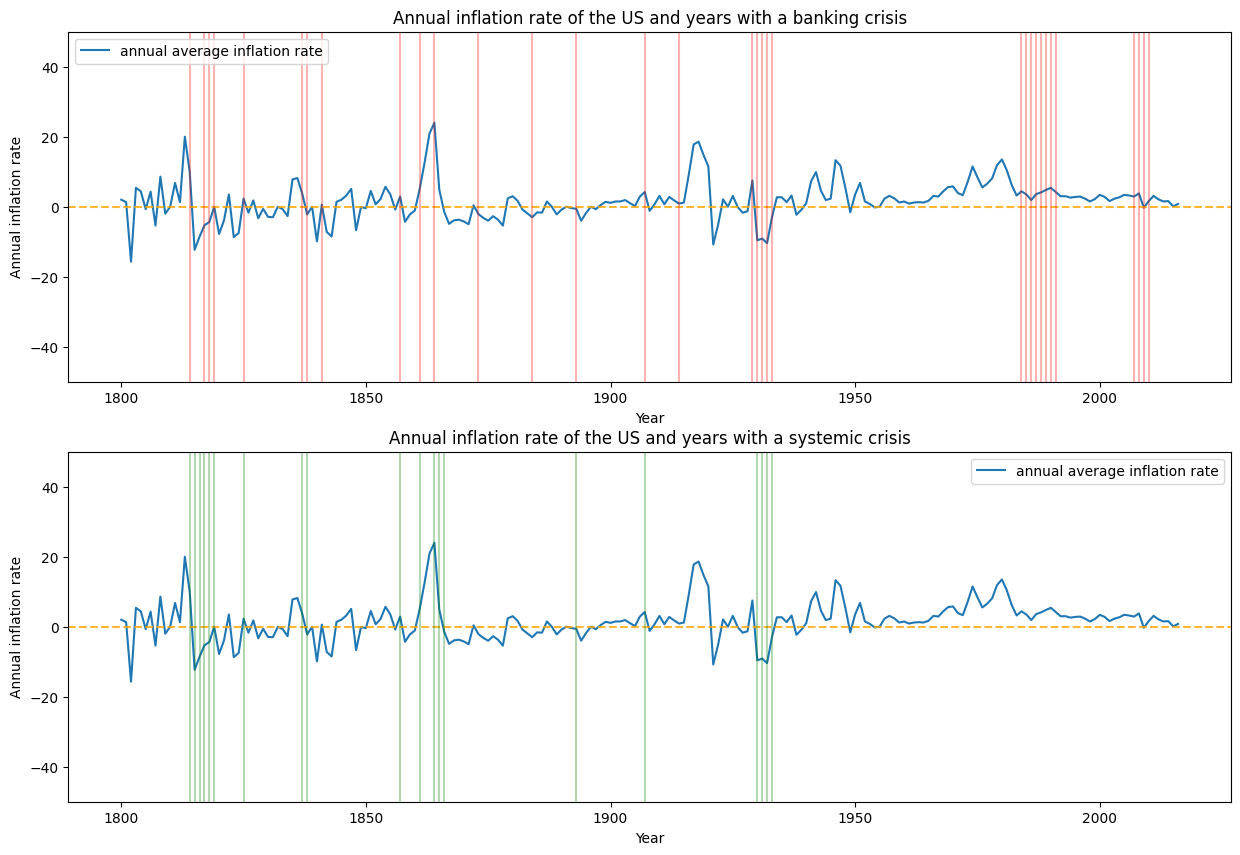

In [100]:
fig, axs = plt.subplots(2, 1, figsize=(15,10))

#Plot the inflation rate with banking crisis as red vertical lines
sns.lineplot(x=USA_data['Year'], y=USA_data['annual_inflation'], label = 'annual average inflation rate', ax=axs[0])

axs[0].axhline(y=0, color='orange', label='y=0', linestyle = 'dashed', alpha = 0.8)

for year in banking_crisis_years:
    axs[0].axvline(x=year, color='red', linestyle='-', label='Crisis Period', alpha = 0.3,)

axs[0].set_ylim(-50, 50)

axs[0].set_title('Annual inflation rate of the US and years with a banking crisis')
axs[0].set_xlabel('Year')
axs[0].set_ylabel('Annual inflation rate')

#Plot the inflation rate with systemic crisis as green vertical lines
sns.lineplot(x=USA_data['Year'], y=USA_data['annual_inflation'], label = 'annual average inflation rate', ax=axs[1])

axs[1].axhline(y=0, color='orange', label='y=0', linestyle = 'dashed', alpha = 0.8)

for year in systemic_crisis_years:
    axs[1].axvline(x=year, color='green', linestyle='-', label='Systemic crisis Period', alpha = 0.3)

axs[1].set_ylim(-50, 50)

axs[1].set_title('Annual inflation rate of the US and years with a systemic crisis')
axs[1].set_xlabel('Year')
axs[1].set_ylabel('Annual inflation rate')

plt.savefig('../figures/banking_crisis_overview.png')
plt.show()

Comments: Systemic crisis occur in the same years as Banking crisis and we can choose to disregard them whle studying for negative demand shock. 

## 2.3 Estimate the average response to negative liquidity shock

### 2.3.1 Defining functions to plot the data

I first define a function that can extract a serie from 1 year previous the shock to six years after.

In [101]:
def extract_inflation_series(data, target_year):
    target_index = data[data['Year'] == target_year].index[0]
    series = data.loc[target_index-1:target_index+6, 'annual_inflation']
    return np.array(series)

In [102]:
years = []
for i in range (-1,7):
    if i<0:
        years.append(f"t{i}")
    elif i==0:
        years.append(f"t")
    else:
        years.append(f"t+{i}")
years


['t-1', 't', 't+1', 't+2', 't+3', 't+4', 't+5', 't+6']

### 2.3.2 Treat each year of crises as an individual event

I first extract the series for each event of banking crisis in the dataset. 

In [103]:
inflation_series_all = []
for year in banking_crisis_years:
    inflation_series_all.append(extract_inflation_series(USA_data, year))
inflation_series_all = np.array(inflation_series_all)

I then normalize the serie to the first data of the serie at time t-1. 

In [104]:
norm_inflation_series_all = []
for array in inflation_series_all:
    norm_inflation_series_all.append(array - array[0])
norm_inflation_series_all = np.array(norm_inflation_series_all)

I compute the average pattern by taking the mean of the normalized series, and the confidence interval of the pattern defned as 1.96*(standard deviation) divided by the squared root of the number of series.

In [105]:
average_pattern = np.mean(norm_inflation_series_all, axis=0)
confidence_interval = 1.96 * np.std(norm_inflation_series_all, axis=0) / np.sqrt(norm_inflation_series_all.shape[0])

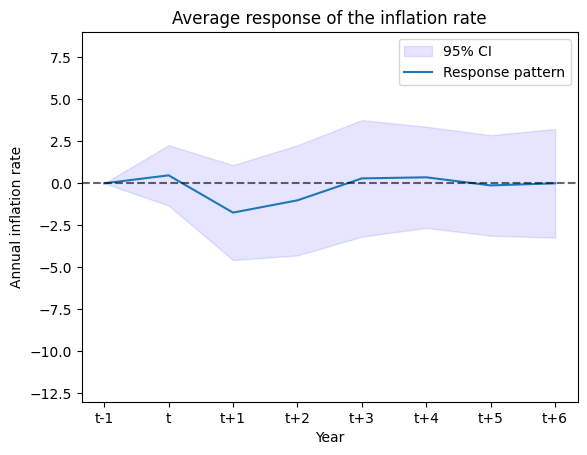

In [106]:
plt.title('Average response of the inflation rate')
plt.fill_between(
    range(len(average_pattern)),
    average_pattern - confidence_interval,
    average_pattern + confidence_interval,
    color='blue',
    alpha=0.1, label='95% CI'
)

sns.lineplot(x=years, y=average_pattern, label = 'Response pattern')
plt.axhline(y=0, color='black', label='y=0', linestyle = 'dashed', alpha = 0.6)

plt.xlabel('Year')
plt.ylabel('Annual inflation rate')

plt.ylim(-13,9)
plt.show()

### 2.3.3 Count only the beginning of the crises and treat the series as one event

A other approach to record the crisis event in the data is to <u> consider the period when crisis occur during consecutive years only as one crisis</u> , time t being the year when the first state of crisis was recorded. 

In [107]:
banking_crisis_first_year = [banking_crisis_years[0]]
for i in range (1, len(banking_crisis_years)):
    if banking_crisis_years[i]-banking_crisis_years[i-1]>=2:
        banking_crisis_first_year.append(banking_crisis_years[i])
print(f'In this aproch, we record {len(banking_crisis_first_year)} different crisis event.')

In this aproch, we record 16 different crisis event.


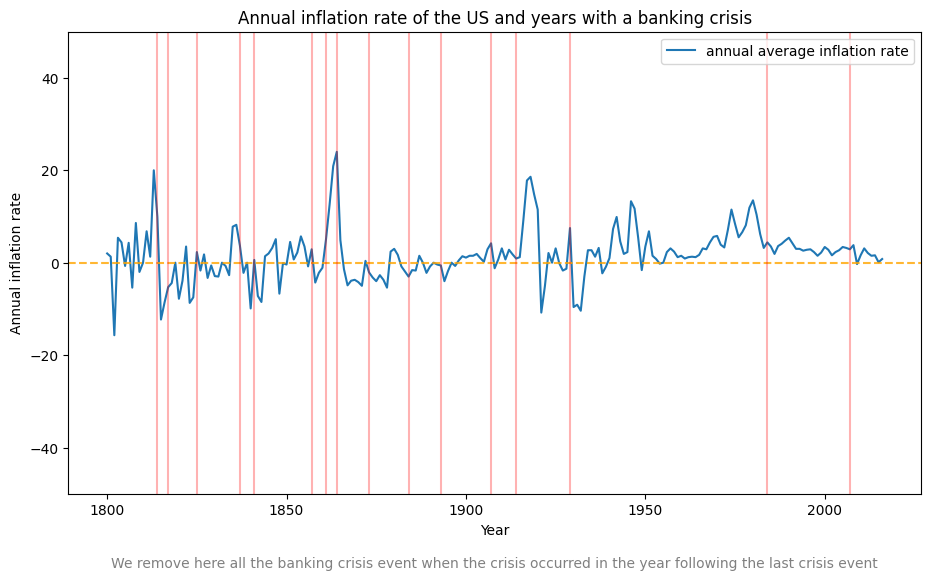

In [108]:
plt.figure(figsize=(11,6))

sns.lineplot(x=USA_data['Year'], y=USA_data['annual_inflation'], label = 'annual average inflation rate')
plt.axhline(y=0, color='orange', label='y=0', linestyle = 'dashed', alpha = 0.8)

for year in banking_crisis_first_year:
    plt.axvline(x=year, color='red', linestyle='-', label='Crisis Period', alpha = 0.3)

plt.ylim(-50, 50)

plt.title('Annual inflation rate of the US and years with a banking crisis')
plt.xlabel('Year')
plt.ylabel('Annual inflation rate')

subtitle_text = "We remove here all the banking crisis event when the crisis occurred in the year following the last crisis event"
plt.annotate(subtitle_text,
             xy=(0.5, -0.15),  # Position of the text (relative to the plot)
             xycoords='axes fraction',
             ha='center', va='center',  # Centered text
             fontsize=10,
             color='gray')

plt.show()

We extract the series for the years selected, normalize them and compute the average pattern among them.

In [109]:
inflation_series = []
for year in banking_crisis_first_year:
    series_for_year = extract_inflation_series(USA_data, year)
    inflation_series.append(series_for_year)
inflation_series = np.array(inflation_series)

In [110]:
norm_inflation_series = []
for array in inflation_series:
    norm_inflation_series.append(array - array[0])
norm_inflation_series = np.array(norm_inflation_series)

In [111]:
average_pattern = np.mean(norm_inflation_series, axis=0)
confidence_interval = 1.96 * np.std(norm_inflation_series, axis=0) / np.sqrt(norm_inflation_series.shape[0])

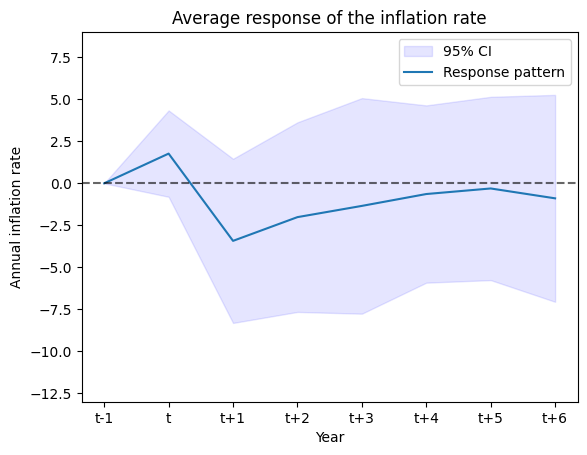

In [112]:
plt.fill_between(
    range(len(average_pattern)),
    average_pattern - confidence_interval,
    average_pattern + confidence_interval,
    color='blue',
    alpha=0.1, label='95% CI'
)

sns.lineplot(x=years, y=average_pattern, label = 'Response pattern')
plt.axhline(y=0, color='black', label='y=0', linestyle = 'dashed', alpha = 0.6)

plt.title('Average response of the inflation rate')
plt.xlabel('Year')
plt.ylabel('Annual inflation rate')

plt.ylim(-13,9)
plt.show()

### 2.3.4 Count only the beginning of the crises and treat the series as one event with adding a larger weight on a multi-year crisis

An other approach is still to consider the first year of crisis as the event of the crisis, but to also computing the average pattern of the inflation rate with the weights of the duration of the crisis. For example, a crisis that last for three years will count three time as much as a crisis that last for one year only. <br>  
We first need to extract the length of each of the crisis event recorded. 

In [113]:
crisis_duration = []
current_length = 0

for value in USA_data['banking_crisis']:
    if value == 1:
        current_length += 1
    elif current_length > 0:
        crisis_duration.append(current_length)
        current_length = 0

# Check if the last sequence extends to the end of the dataset
if current_length > 0:
    crisis_duration.append(current_length)

print(crisis_duration)

[1, 3, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 8, 4]


In [114]:
len(crisis_duration)

16

In [115]:
weighted_average_pattern = np.average(norm_inflation_series, axis=0, weights=crisis_duration)
weighted_std = np.sqrt(np.average((norm_inflation_series - weighted_average_pattern)**2, axis=0, weights=crisis_duration))
weighted_confidence_interval = 1.96 * weighted_std / np.sqrt(sum(crisis_duration))

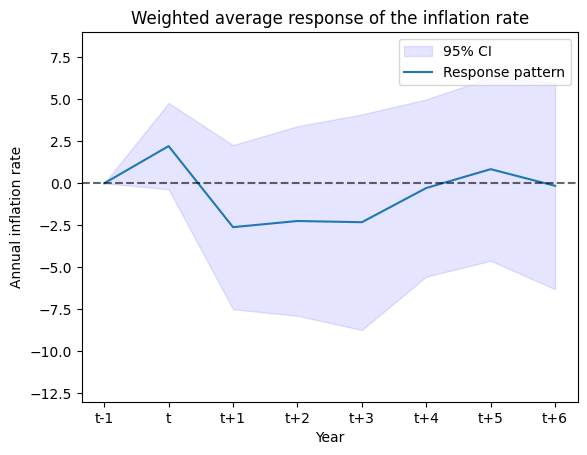

In [116]:
plt.fill_between(
    range(len(weighted_average_pattern)),
    weighted_average_pattern - confidence_interval,
    weighted_average_pattern + confidence_interval,
    color='blue',
    alpha=0.1, label='95% CI'
)

sns.lineplot(x=years, y=weighted_average_pattern, label = 'Response pattern')
plt.axhline(y=0, color='black', label='y=0', linestyle = 'dashed', alpha = 0.6)

plt.title('Weighted average response of the inflation rate')
plt.xlabel('Year')
plt.ylabel('Annual inflation rate')

plt.ylim(-13,9)
plt.show()

# 3. Estimating the GDP response to liquidity shocks - focus on the USA

I use here the GDP data provided by the Maddison Project Database in 2020. The database covers 169 countries and the period up to 2018. 

## 3.1 Extract the US data

In [117]:
GDP_pc = pd.read_csv('../raw_data/gdp-per-capita-maddison.csv')
GDP_pc.drop(columns='417485-annotations', inplace = True)
GDP_pc.rename(columns={'GDP per capita':'GDP_per_capita'}, inplace = True)
GDP_pc.dtypes

Entity             object
Code               object
Year                int64
GDP_per_capita    float64
dtype: object

In [118]:
US_GDP_pc = GDP_pc.loc[GDP_pc['Entity']=='United States']
US_GDP_pc.head()

,Entity,Code,Year,GDP_per_capita
18834,United States,USA,1650,897.0000
18835,United States,USA,1720,1768.9856
18836,United States,USA,1775,2419.0000
18837,United States,USA,1800,2545.4880
18838,United States,USA,1801,2591.7695


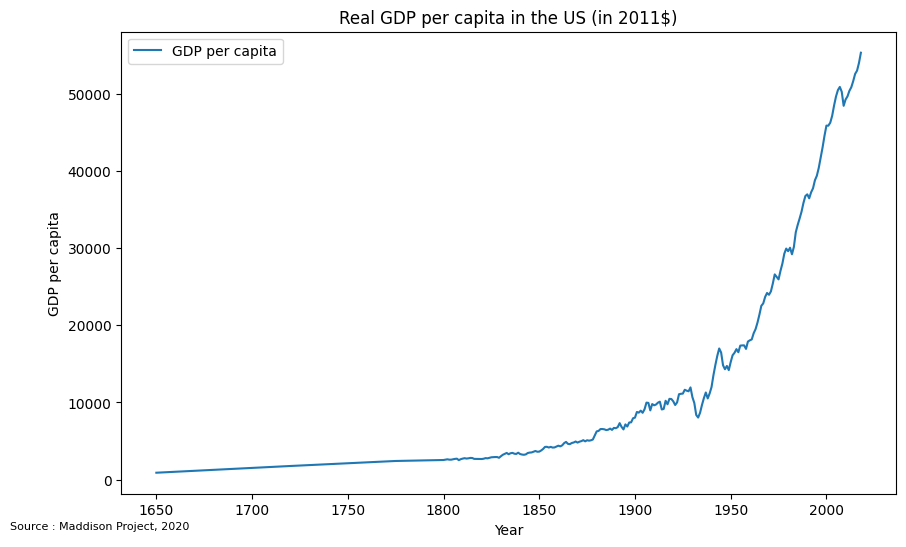

In [119]:
plt.figure(figsize=(10,6))

sns.lineplot(x=US_GDP_pc['Year'], y=US_GDP_pc['GDP_per_capita'], label = 'GDP per capita')

plt.title('Real GDP per capita in the US (in 2011$)')

plt.xlabel('Year')
plt.ylabel('GDP per capita')

plt.annotate('Source : Maddison Project, 2020', (0,0), (-80,-20), fontsize=8,
             xycoords='axes fraction', textcoords='offset points', va='top')

plt.show()

## 3.2 Compute the output gap

### 3.2.1 Detrend output

In [120]:
cycle, trend = sm.tsa.filters.hpfilter(US_GDP_pc.GDP_per_capita, 6.25)


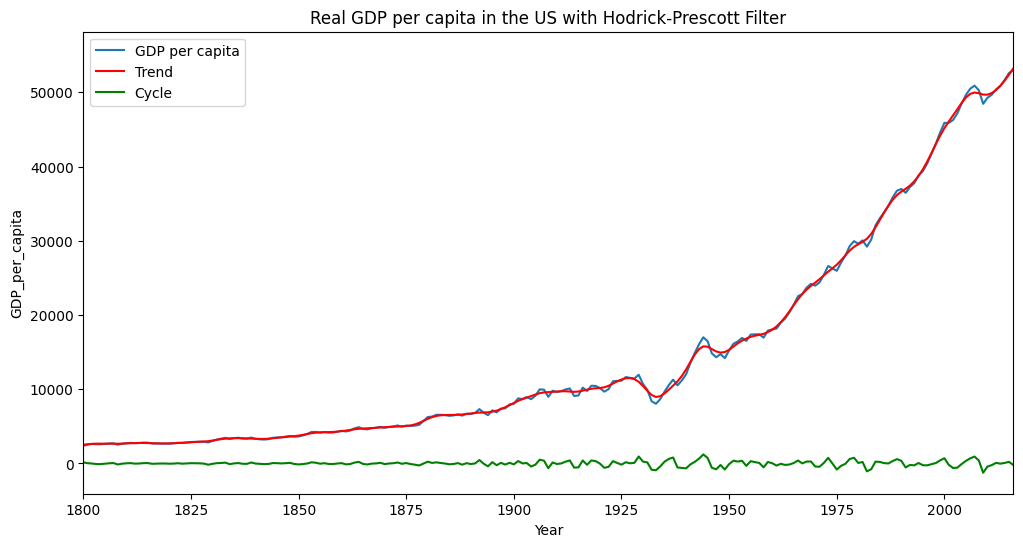

In [121]:
# Plot the original GDP, trend, and cycle
plt.figure(figsize=(12, 6))

sns.lineplot(x=US_GDP_pc.Year, y=US_GDP_pc.GDP_per_capita, label = 'GDP per capita')
sns.lineplot(x=US_GDP_pc.Year, y=trend, label = 'Trend', color = 'red')
sns.lineplot(x=US_GDP_pc.Year, y=cycle, label = 'Cycle', color = 'green')

plt.xlim((1800, 2016))

plt.title('Real GDP per capita in the US with Hodrick-Prescott Filter')
plt.xlabel('Year')
plt.legend()
plt.show()

In [122]:
trend_deviation = pd.DataFrame({
    'Year' : US_GDP_pc.Year,
    'output_gap' : ((US_GDP_pc.GDP_per_capita - trend)/trend)*100})
trend_deviation.head()

,Year,output_gap
18834,1650,-29.208019
18835,1720,3.082373
18836,1775,14.869326
18837,1800,6.698333
18838,1801,1.443674


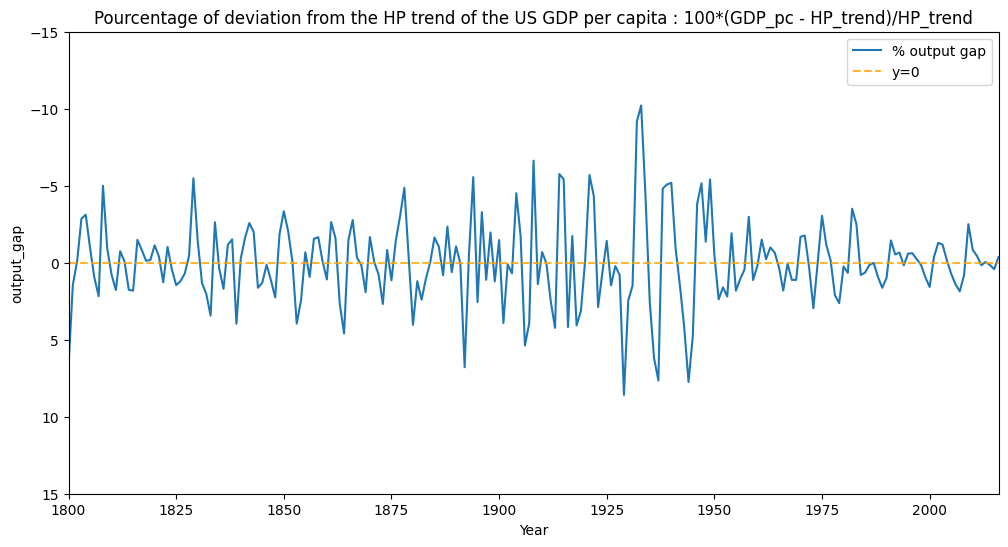

In [123]:
plt.figure(figsize=(12, 6))

sns.lineplot(x=trend_deviation.Year, y=trend_deviation['output_gap'], label = '% output gap')
plt.axhline(y=0, color='orange', label='y=0', linestyle = 'dashed', alpha = 0.8)

plt.title('Pourcentage of deviation from the HP trend of the US GDP per capita : 100*(GDP_pc - HP_trend)/HP_trend')
plt.xlabel('Year')
plt.xlim((1800, 2016))
plt.ylim((15,-15))

plt.legend()
plt.show()

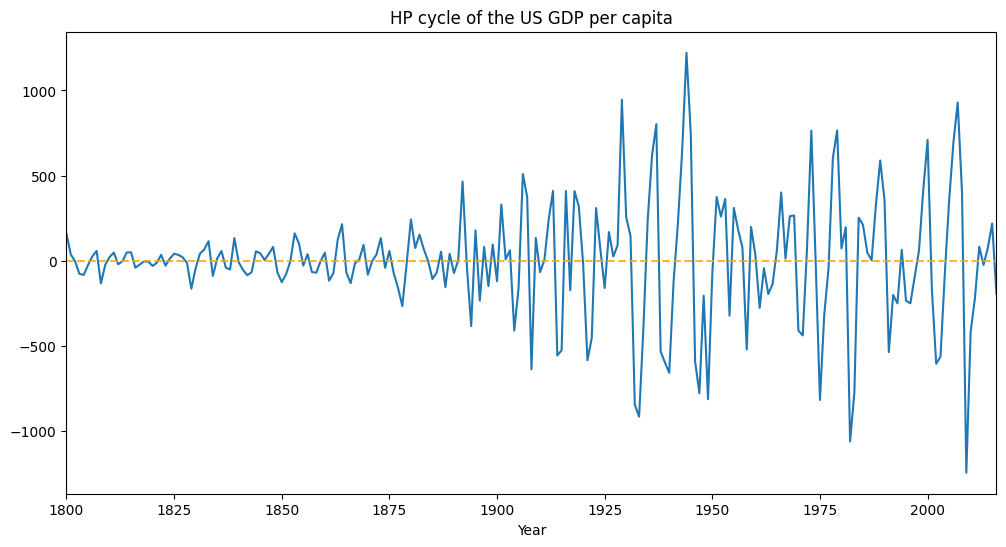

In [124]:
plt.figure(figsize=(12, 6))

sns.lineplot(x=US_GDP_pc.Year, y=cycle)
plt.axhline(y=0, color='orange', label='y=0', linestyle = 'dashed', alpha = 0.8)

plt.title('HP cycle of the US GDP per capita')
plt.xlabel('Year')
plt.ylabel('')

plt.xlim((1800, 2016))

plt.show()

### 3.2.2 With output gap data

I take the quaterly data of Real Potential GDP issued by FRED from 1950 to 2025. I want to convert the data to annual data fr comparison purpose with my previous work.

In [125]:
US_GDPPOT = pd.read_csv('../raw_data/USA/GDPPOT.csv')
US_GDPPOT['DATE'] = pd.to_datetime(US_GDPPOT['DATE'])
US_GDPPOT.head()

,DATE,GDPPOT
0,1950-01-01,2218.566586
1,1950-04-01,2248.161822
2,1950-07-01,2277.049682
3,1950-10-01,2306.715167
4,1951-01-01,2336.504742


In [126]:
# Resample the data to annual frequency by taking the mean of the quarters for each year
US_GDPPOT_annual = US_GDPPOT.resample('A', on='DATE').mean()
US_GDPPOT_annual.reset_index(inplace=True)
US_GDPPOT_annual['DATE'] = US_GDPPOT_annual['DATE'].dt.year

#As the data is expressed in Billions of Dollars, I multiply the TS by 10**9.
US_GDPPOT_annual['GDPPOT'] = US_GDPPOT_annual['GDPPOT']*10**9

#Filter the data from 1950 to 2018.
US_GDPPOT_annual = US_GDPPOT_annual[(US_GDPPOT_annual['DATE'] >= 1950) & (US_GDPPOT_annual['DATE'] <= 2018)]
US_GDPPOT_annual.set_index('DATE', inplace= True)

I import a database of the population in the US to compute the Real Potential GDP per capita.

In [127]:
US_pop =pd.read_csv('../raw_data/USA/Population.csv')
US_pop.DATE = pd.to_datetime(US_pop.DATE)
US_pop['DATE'] = US_pop['DATE'].dt.year

#As the data is expressed in Thousands, I multiply the TS by 10**3.
US_pop['POPULATION'] = US_pop['POPULATION']*10**3

#Filter the data from 1950 to 2018.
US_pop = US_pop[(US_pop['DATE'] >= 1950) & (US_pop['DATE'] <= 2018)]
US_pop.set_index('DATE', inplace= True)

In [128]:
US_GDPPOT_pc = pd.DataFrame({'GDPPOT_pc':US_GDPPOT_annual['GDPPOT']/US_pop['POPULATION']})
US_GDPPOT_pc.head()

,GDPPOT_pc
DATE,
1950,14916.690714
1951,15444.755071
1952,16073.021841
1953,16570.956833
1954,16744.828838


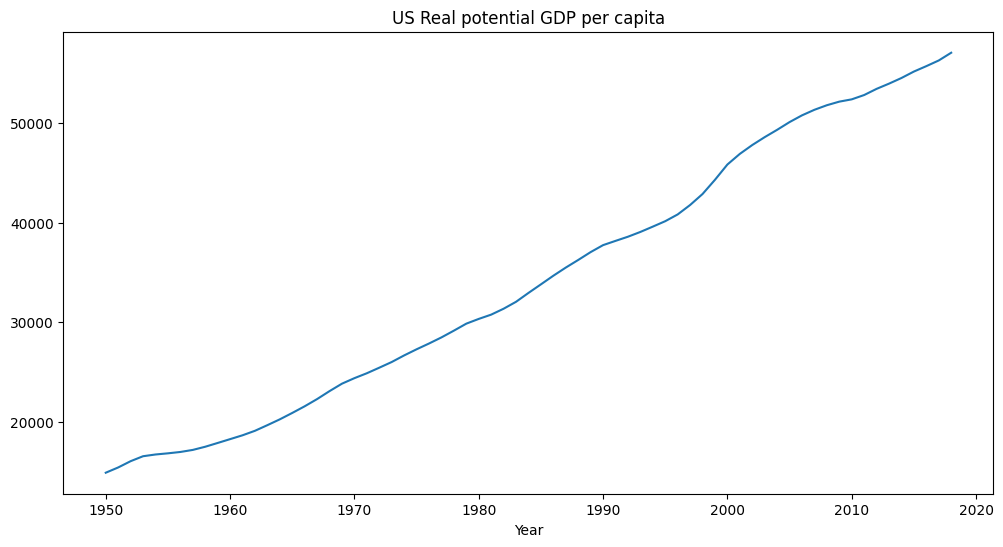

In [153]:
plt.figure(figsize=(12, 6))

sns.lineplot(x=US_GDPPOT_pc.index, y=US_GDPPOT_pc['GDPPOT_pc'])

plt.title('US Real potential GDP per capita')
plt.xlabel('Year')
plt.ylabel('')

plt.show()

We now compute the output gap by using the US_GDP_pc database. 

In [129]:
US_GDP_pc_filtered = US_GDP_pc[(US_GDP_pc['Year'] >= 1950) & (US_GDP_pc['Year'] <= 2018)]
US_GDP_pc_filtered.set_index(US_GDPPOT_pc.index, inplace=True)

#Compute the pourcentage of deviation of the output gap
Percent_output_gap = 100*(US_GDP_pc_filtered['GDP_per_capita'] - US_GDPPOT_pc['GDPPOT_pc'])/US_GDPPOT_pc['GDPPOT_pc']

Percent_output_gap = pd.DataFrame({'%_Output_gap_pc': Percent_output_gap})
Percent_output_gap.head()

,%_Output_gap_pc
DATE,
1950,2.167433
1951,4.404375
1952,2.308080
1953,2.088251
1954,-1.390452


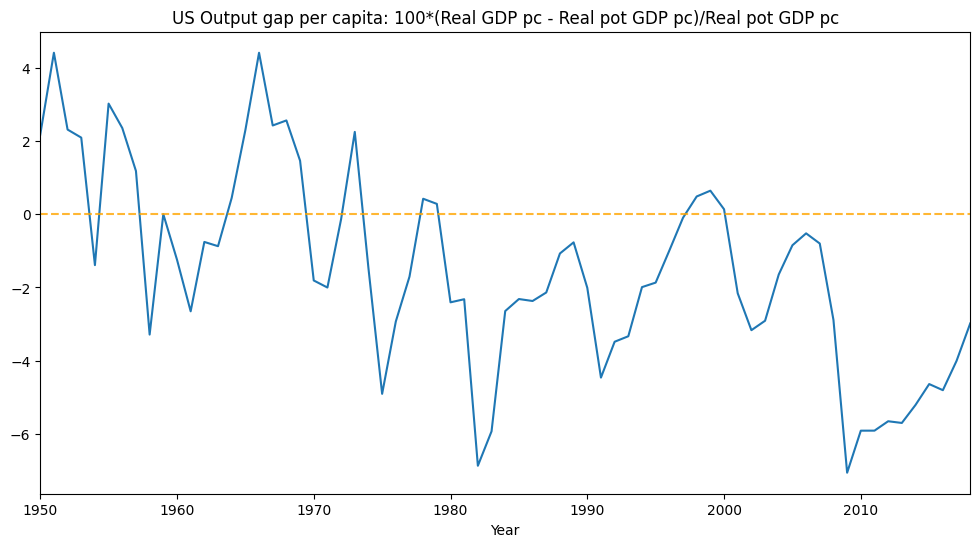

In [154]:
plt.figure(figsize=(12, 6))

sns.lineplot(x=Percent_output_gap.index, y=Percent_output_gap['%_Output_gap_pc'])

plt.axhline(y=0, color='orange', label='y=0', linestyle = 'dashed', alpha = 0.8)

plt.title('US Output gap per capita: 100*(Real GDP pc - Real pot GDP pc)/Real pot GDP pc')
plt.xlabel('Year')
plt.ylabel('')

plt.xlim(1950,2018)

plt.show()

### 3.2.3 With unemployment rate data

## 3.3 Compute the shock response in the output gap

### 3.3.1 Define functions to plot the data

I first define a function to extract the data from the dataset. 

In [131]:
def extract_output_gap_series(data, target_year):
    target_index = data[data['Year'] == target_year].index[0]
    series = data.loc[target_index-1:target_index+6, 'output_gap']
    return np.array(series)

### 3.3.2 Treat each year of crises as an individual event

I first extract the series for each event of banking crisis in the dataset. 

In [132]:
output_gap_series_all = []
for year in banking_crisis_years:
    output_gap_series_all.append(extract_output_gap_series(trend_deviation, year))
output_gap_series_all = np.array(output_gap_series_all)

I then normalize the serie to the first data of the serie at time t-1. 

In [133]:
norm_output_gap_series_all = []
for array in output_gap_series_all:
    norm_output_gap_series_all.append(array - array[0])
norm_output_gap_series_all = np.array(norm_output_gap_series_all)

I compute the average pattern by taking the mean of the normalized series, and the confidence interval of the pattern defned as 1.96*(standard deviation) divided by the squared root of the number of series.

In [134]:
average_pattern = np.mean(norm_output_gap_series_all, axis=0)
confidence_interval = 1.96 * np.std(norm_output_gap_series_all, axis=0) / np.sqrt(norm_output_gap_series_all.shape[0])

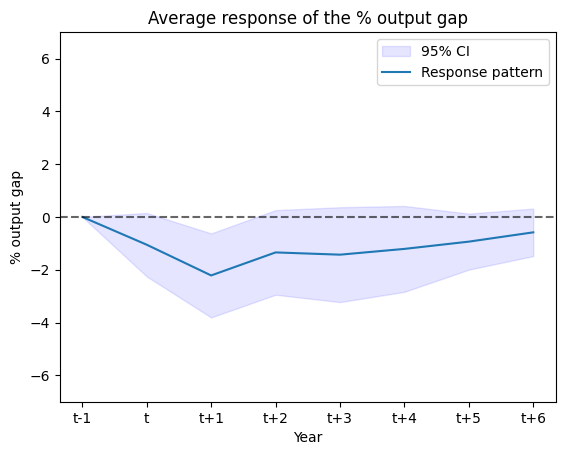

In [135]:
plt.title('Average response of the % output gap')
plt.fill_between(
    range(len(average_pattern)),
    average_pattern - confidence_interval,
    average_pattern + confidence_interval,
    color='blue',
    alpha=0.1, label='95% CI'
)

sns.lineplot(x=years, y=average_pattern, label = 'Response pattern')
plt.axhline(y=0, color='black', label='y=0', linestyle = 'dashed', alpha = 0.6)

plt.xlabel('Year')
plt.ylabel('% output gap')

plt.ylim(-7,7)
plt.show()

### 3.3.2 Count only the beginning of the crises and treat the series as one event

I plot the output gap series with the banking crisis year.

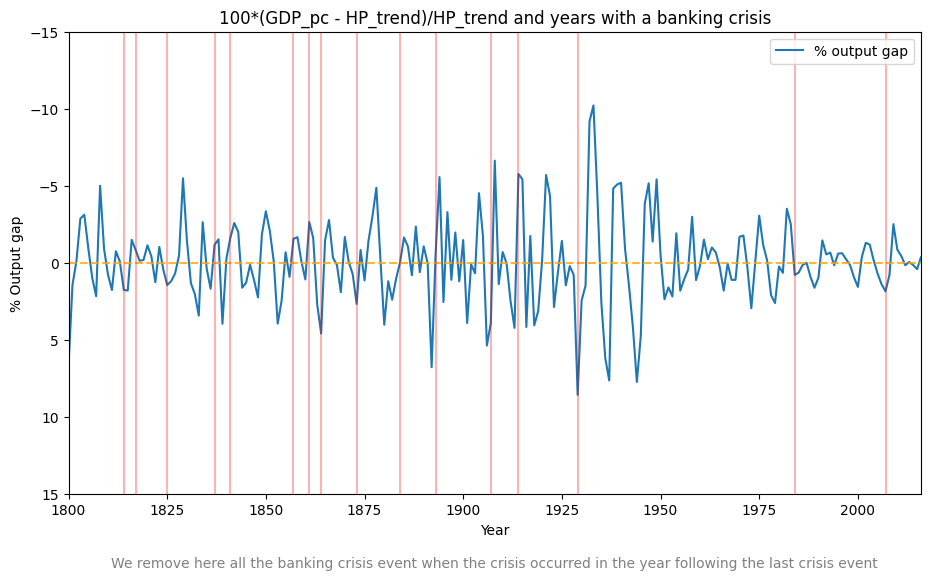

In [155]:
plt.figure(figsize=(11,6))

sns.lineplot(x=trend_deviation.Year, y=trend_deviation['output_gap'], label = '% output gap')
plt.axhline(y=0, color='orange', label='y=0', linestyle = 'dashed', alpha = 0.8)

for year in banking_crisis_first_year:
    plt.axvline(x=year, color='red', linestyle='-', label='Crisis Period', alpha = 0.3)

plt.xlim((1800, 2016))
plt.ylim((15,-15))

plt.title('100*(GDP_pc - HP_trend)/HP_trend and years with a banking crisis')
plt.xlabel('Year')
plt.ylabel('% Output gap')

subtitle_text = "We remove here all the banking crisis event when the crisis occurred in the year following the last crisis event"
plt.annotate(subtitle_text,
             xy=(0.5, -0.15),  # Position of the text (relative to the plot)
             xycoords='axes fraction',
             ha='center', va='center',  # Centered text
             fontsize=10,
             color='gray')

plt.show()

I extract a serie of the output gap for each banking crisis year, normalize them to time t-1 and compute the averagere response. 

In [137]:
output_gap_series = []
for year in banking_crisis_first_year:
    output_series_for_year = extract_output_gap_series(trend_deviation, year)
    output_gap_series.append(output_series_for_year)
output_gap_series = np.array(output_gap_series)

In [138]:
norm_output_gap_series = []
for array in output_gap_series:
    norm_output_gap_series.append(array - array[0])
norm_output_gap_series = np.array(norm_output_gap_series)

In [139]:
average_pattern_output_gap = np.mean(norm_output_gap_series, axis=0)
confidence_interval = 1.96 * np.std(norm_output_gap_series, axis=0) / np.sqrt(norm_output_gap_series.shape[0])

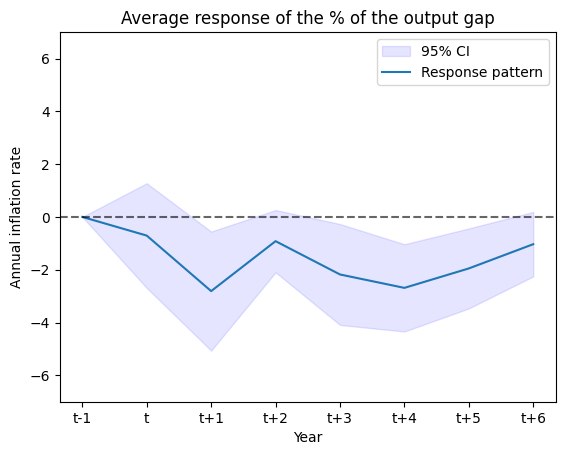

In [140]:
plt.fill_between(
    range(len(average_pattern_output_gap)),
    average_pattern_output_gap - confidence_interval,
    average_pattern_output_gap + confidence_interval,
    color='blue',
    alpha=0.1, label='95% CI'
)

sns.lineplot(x=years, y=average_pattern_output_gap, label = 'Response pattern')
plt.axhline(y=0, color='black', label='y=0', linestyle = 'dashed', alpha = 0.6)

plt.title('Average response of the % of the output gap')
plt.xlabel('Year')
plt.ylabel('Annual inflation rate')

plt.ylim(-7,7)
plt.show()

## 3.4 Comput the response in the GDP per capita

### 3.4.1 Functions to plot the data

In [160]:
US_GDP_pc.dtypes

Entity             object
Code               object
Year                int64
GDP_per_capita    float64
dtype: object

In [162]:
def extract_output_series(data, target_year):
    target_index = data[data['Year'] == target_year].index[0]
    series = data.loc[target_index-1:target_index+6, 'GDP_per_capita']
    return np.array(series)

In [164]:
output_series = []
for year in banking_crisis_first_year:
    output_series_for_year = extract_output_series(US_GDP_pc, year)
    output_series.append(output_series_for_year)
output_series = np.array(output_series)

In [165]:
norm_output_series = []
for array in output_series:
    norm_output_series.append(array - array[0])
norm_output_series = np.array(norm_output_series)

# 4. Focus on the negative demand shocks

## 4.1 Focus on each crisis recorded

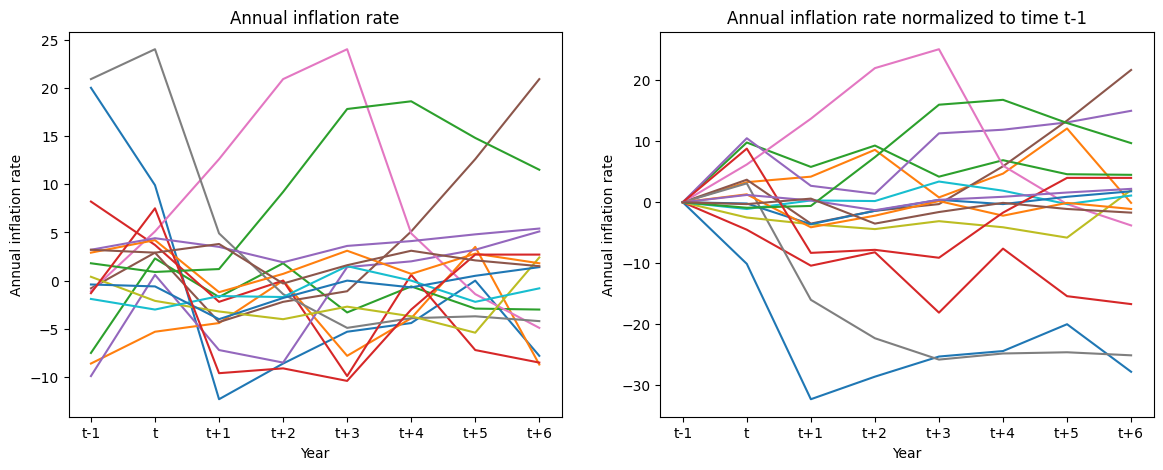

In [141]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.title('Annual inflation rate')
for i in range (0,len(inflation_series)):
    sns.lineplot(x=years, y=inflation_series[i])
plt.xlabel('Year')
plt.ylabel('Annual inflation rate')


plt.subplot(1, 2, 2)
plt.title('Annual inflation rate normalized to time t-1')
for i in range (0,len(norm_inflation_series)):
    sns.lineplot(x=years, y=norm_inflation_series[i])

plt.xlabel('Year')
plt.ylabel('Annual inflation rate')

plt.show()

In [142]:
crisis_dict_inflation = {}
for key, value in zip(banking_crisis_first_year,inflation_series):
    crisis_dict_inflation[f"Crisis of {key}"]=value

In [143]:
crisis_dict_inflation.keys()

dict_keys(['Crisis of 1814', 'Crisis of 1817', 'Crisis of 1825', 'Crisis of 1837', 'Crisis of 1841', 'Crisis of 1857', 'Crisis of 1861', 'Crisis of 1864', 'Crisis of 1873', 'Crisis of 1884', 'Crisis of 1893', 'Crisis of 1907', 'Crisis of 1914', 'Crisis of 1929', 'Crisis of 1984', 'Crisis of 2007'])

In [172]:
crisis_dict_output_gap = {}
for key, value in zip(banking_crisis_first_year,output_gap_series):
    crisis_dict_output_gap[f"Crisis of {key}"]=value

In [173]:
crisis_dict_GDP_pc = {}
for key, value in zip(banking_crisis_first_year,output_series):
    crisis_dict_GDP_pc[f"Crisis of {key}"]=value

In [145]:
keys_to_remove = ['Crisis of 1825', 'Crisis of 1837', 'Crisis of 1857','Crisis of 1884','Crisis of 1907','Crisis of 1914' ]
sample_crisis = {key: value for key, value in crisis_dict_inflation.items() if key not in keys_to_remove}

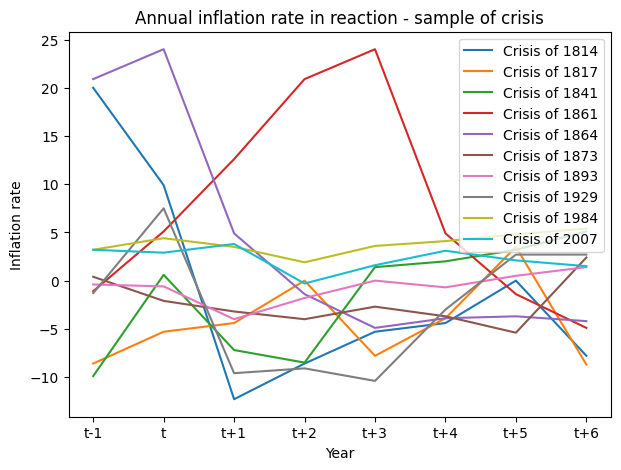

In [146]:
plt.figure(figsize=(7,5))

for key,value in sample_crisis.items():
    sns.lineplot(x=years, y=value, label=key)
plt.title('Annual inflation rate in reaction - sample of crisis')

plt.legend(loc='upper right')
plt.xlabel('Year')
plt.ylabel('Inflation rate')

plt.savefig('../figures/crisis_sample.png')

plt.show()

## 4.2 Inflation rate : examine the difference in the response in each of the crisis

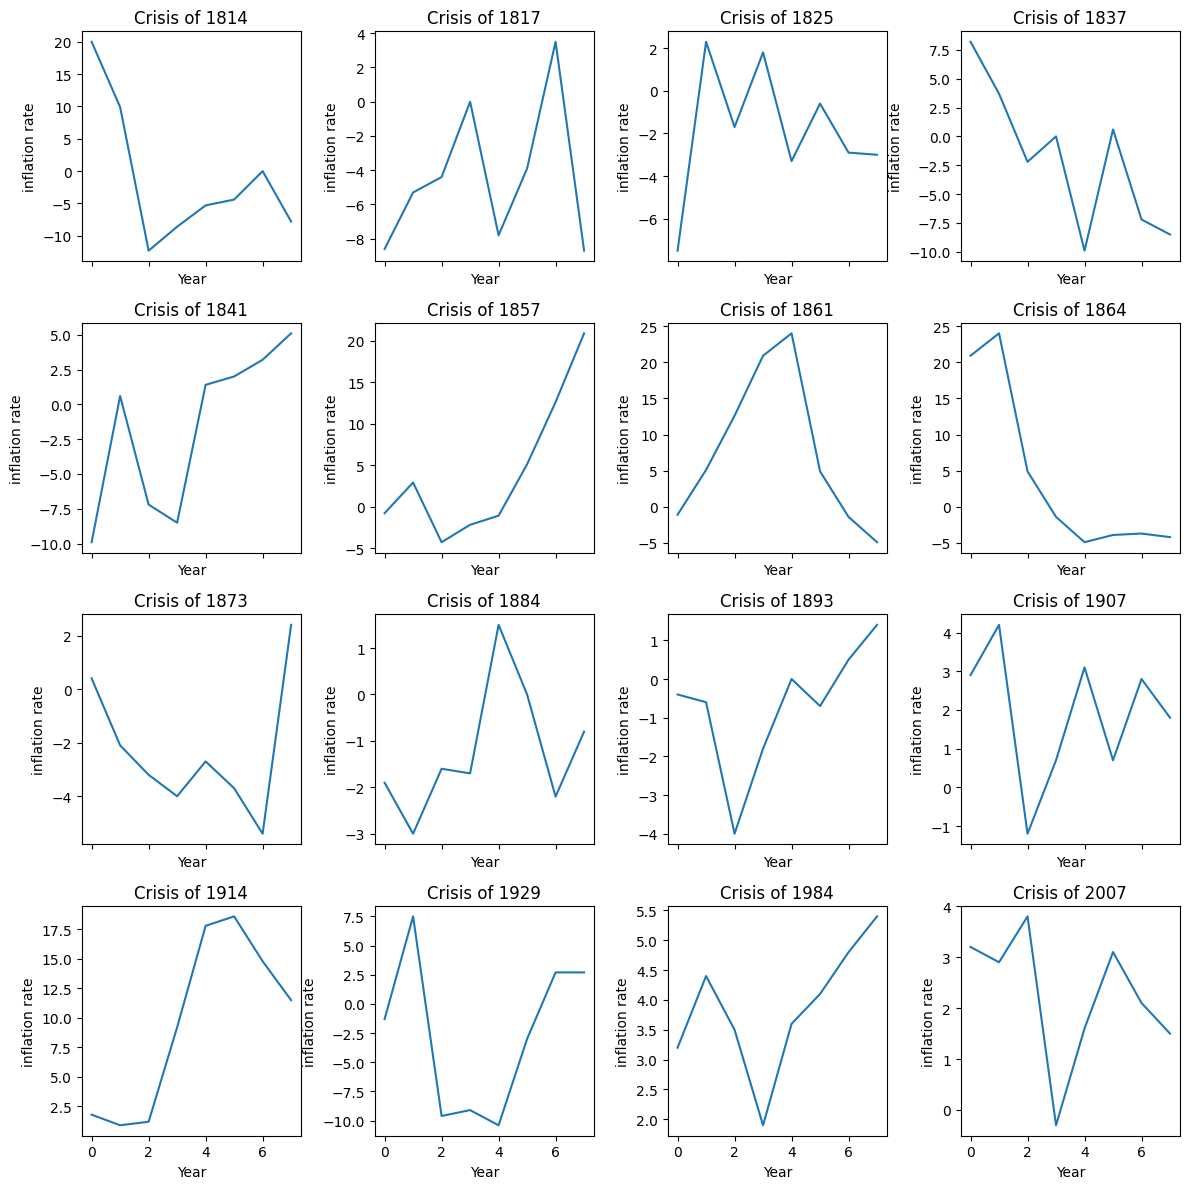

In [147]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(12, 12), sharex=True)

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Plot each series in a separate subplot
for i, (series_name, series_data) in enumerate(crisis_dict_inflation.items()):
    row = i // 4
    col = i % 4
    axes[i].plot(series_data, label=series_name)
    axes[i].set_title(series_name)
    axes[i].set_xlabel('Year')
    axes[i].set_ylabel('inflation rate')
    # axes[i].legend()

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

## 4.3 Output gap : examine the difference in the response in each of the crisis

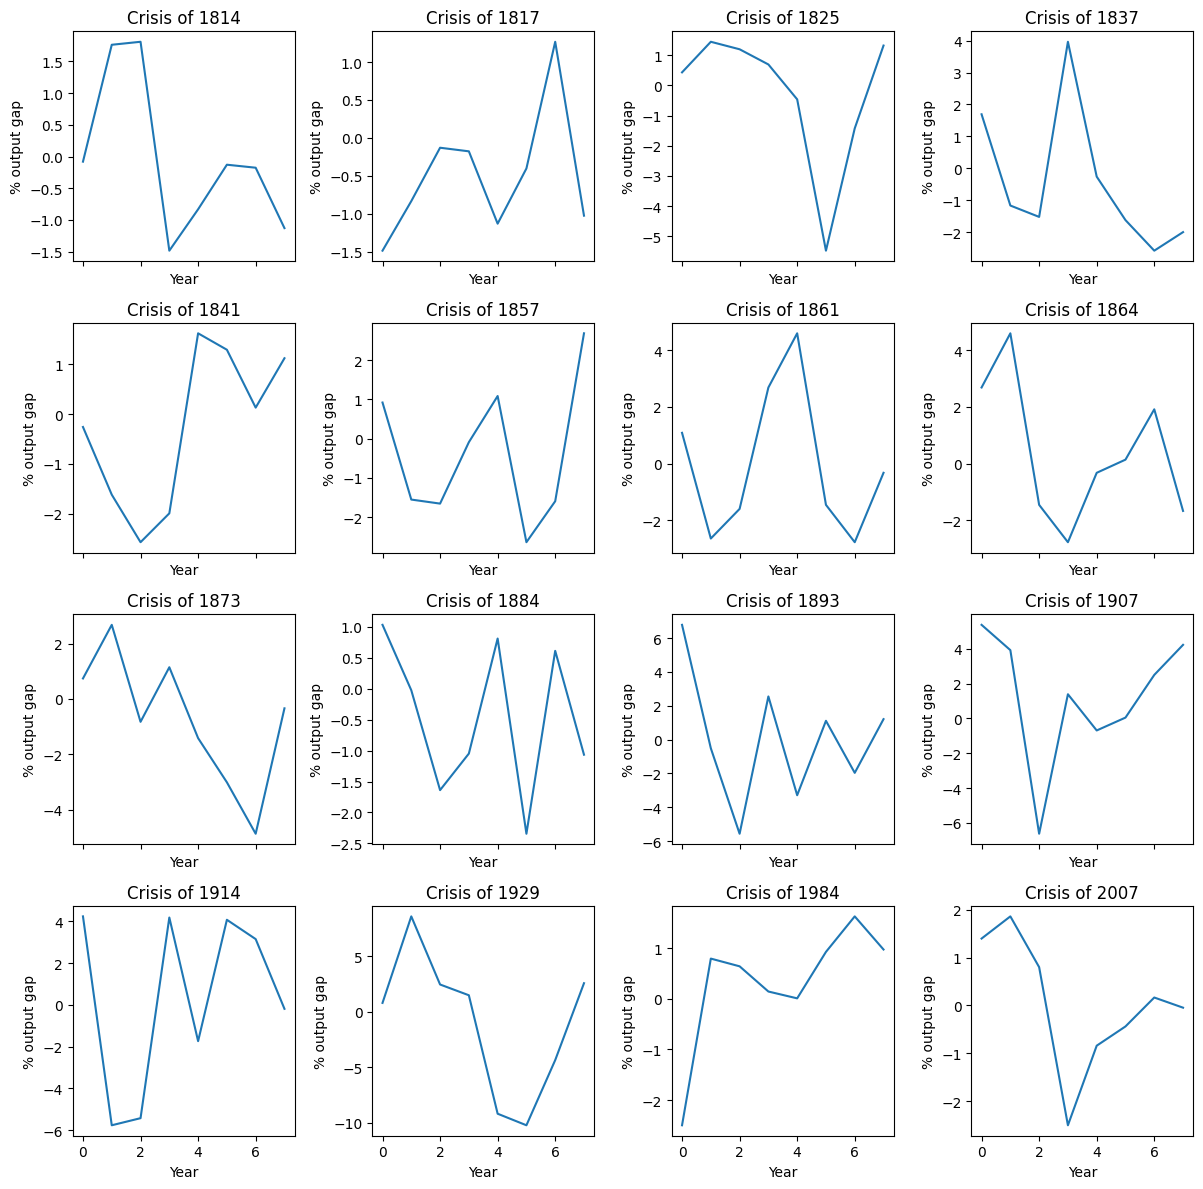

In [148]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(12, 12), sharex=True)

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Plot each series in a separate subplot
for i, (series_name, series_data) in enumerate(crisis_dict_output_gap.items()):
    row = i // 4
    col = i % 4
    axes[i].plot(series_data, label=series_name)
    axes[i].set_title(series_name)
    axes[i].set_xlabel('Year')
    axes[i].set_ylabel('% output gap')
    # axes[i].legend()

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

## 4.4 GDP per capita : examine the difference in the response in each of the crisis

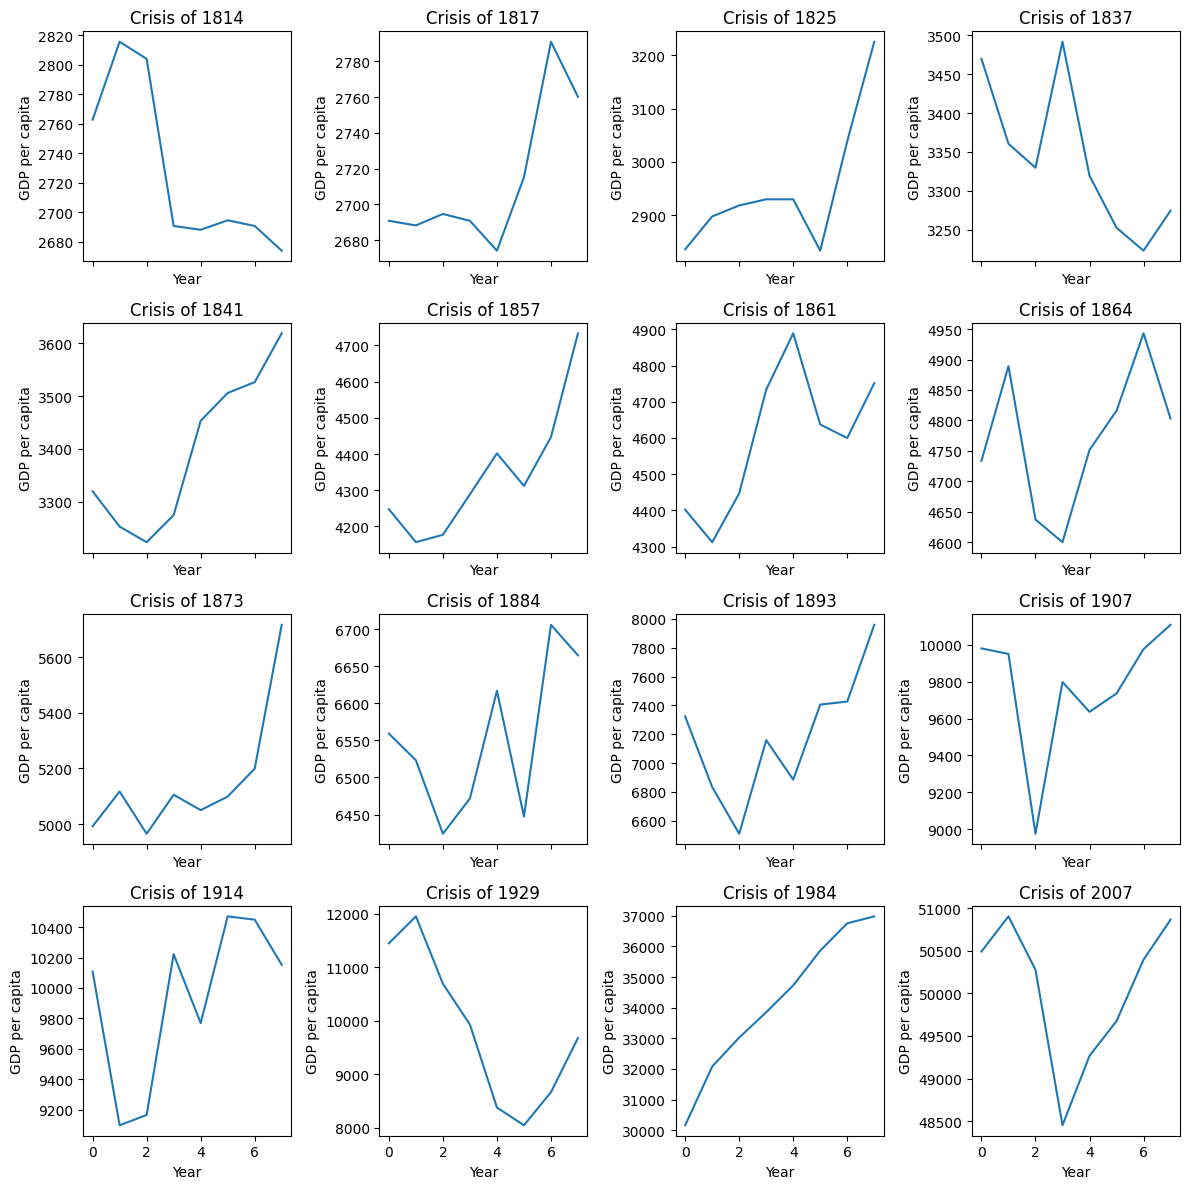

In [176]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(12, 12), sharex=True)

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Plot each series in a separate subplot
for i, (series_name, series_data) in enumerate(crisis_dict_GDP_pc.items()):
    row = i // 4
    col = i % 4
    axes[i].plot(series_data, label=series_name)
    axes[i].set_title(series_name)
    axes[i].set_xlabel('Year')
    axes[i].set_ylabel('GDP per capita')
    # axes[i].legend()

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

# 5. Learning Process - First approach

In [149]:
USA_data['cum_crisis'] = USA_data['banking_crisis'].cumsum()
USA_data['row_number'] = range(1, len(USA_data) + 1)
USA_data['cum_crisis_proba'] = USA_data['cum_crisis']/USA_data['row_number']

/tmp/ipykernel_293065/2671063860.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  USA_data['cum_crisis'] = USA_data['banking_crisis'].cumsum()
/tmp/ipykernel_293065/2671063860.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  USA_data['row_number'] = range(1, len(USA_data) + 1)
/tmp/ipykernel_293065/2671063860.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

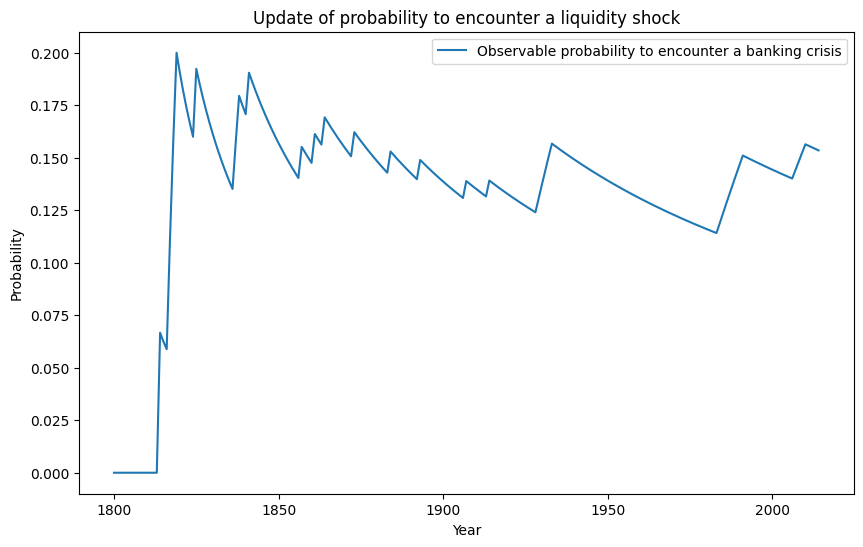

In [150]:
plt.figure(figsize=(10,6))

sns.lineplot(x=USA_data['Year'], y=USA_data['cum_crisis_proba'], label = 'Observable probability to encounter a banking crisis')

plt.title('Update of probability to encounter a liquidity shock')

plt.xlabel('Year')
plt.ylabel('Probability')
plt.legend()

# Bonus : Focus on a crisis: The great Depression

- From the initial Dataset

In [151]:
selected_countries = ['USA', 'JPN', 'FRA', 'ITA', 'ARG']

In [152]:
great_depression = data[(data['Year']>=1928) & (data['Year']<=1940)][['Year', 'annual_inflation', 'Country', 'CC3', 'crisis_and_deflation']]
df = great_depression[great_depression['CC3'].isin(selected_countries)]

KeyError: "['crisis_and_deflation'] not in index"

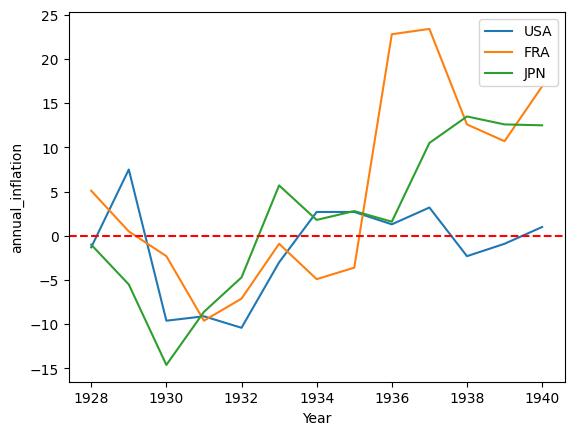

In [ ]:
sns.lineplot(x= 'Year',y='annual_inflation', data = df[df['CC3']=='USA'], label = 'USA')
sns.lineplot(x= 'Year',y='annual_inflation', data = df[df['CC3']=='FRA'], label = 'FRA')
# sns.lineplot(x= 'Year',y='annual_inflation', data = df[df['CC3']=='ITA'], label = 'ITA')
sns.lineplot(x= 'Year',y='annual_inflation', data = df[df['CC3']=='JPN'], label = 'JPN')
plt.axhline(y=0, color='red',linestyle='--')
plt.legend()

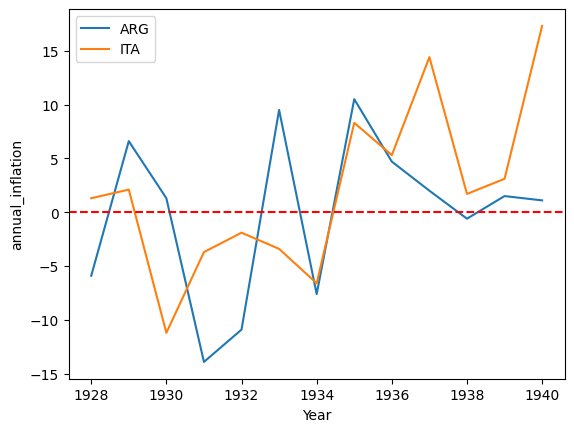

In [ ]:
sns.lineplot(x= 'Year',y='annual_inflation', data = df[df['CC3']=='ARG'], label = 'ARG')
sns.lineplot(x= 'Year',y='annual_inflation', data = df[df['CC3']=='ITA'], label = 'ITA')
plt.axhline(y=0, color='red',linestyle='--')
plt.legend()

- from a more precise quaterly dataset

In [37]:
USA_CPI = pd.read_csv('../raw_data/USA/USA_CPI.csv')